# Paper Annotation Tool using Text Embeddings

> **_Google Colab Note:_** If the notebook fails to run after installing the needed packages, try to restart the runtime (Ctrl + M) under Runtime -> Restart session.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](<colab_link>)

**Notebook Dependencies**

Uncomment the following cell to install all dependencies for this tutorial.

In [1]:
# !pip install scikit-activeml datasets jupyter_ui_poll

<hr style="border-style: solid; border-top: 1px solid; border-right: 0; border-bottom: 0; border-left: 0;">

This notebook showcases an example annotation tool to classify arXiv papers. The overall task is to classify arXiv paper into machine learning papers (cs.AI, cs.LG, cs.CV) and non-machine learning papers (cs.LO, cs.NI, cs.CR, cs.PL) which are class 1 and 0, respectively. We use `ipywidgets` to create the interface, such that users can annotate samples directly within the notebook. The dataset is a subset of the `subset_arxiv_papers_with_embeddings` dataset on [huggingface](https://huggingface.co/datasets/MongoDB/subset_arxiv_papers_with_embeddings) from MongoDB which already provides precomputed embeddings.

> **_NOTE:_** For testing execute this notebook on your local machine or click the Open in Google Colab button above.

In [2]:
import datasets
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import time
import textwrap
from sklearn.model_selection import train_test_split
from IPython.display import display
from jupyter_ui_poll import ui_events

## Dataset

First, we have to create our dataset, which we want to annotate. The papers are filtered according to their assigned category. To simplify the task, we exclude all papers that would belong to both classes. Based on the filtered papers, we subsample a balanced dataset.

In [3]:
random_state = np.random.RandomState(0)


# functions to check if the provided category is indicative of class 0 or 1
def is_c0_category(category):
    return category in ["cs.LO", "cs.NI", "cs.CR", "cs.PL"]


def is_c1_category(category):
    return category in ["cs.AI", "cs.LG", "cs.CV"]


# check if one of the assigned category of a paper is assigned to a class
def is_valid_paper(category_field, category_fn):
    categories = category_field.split()
    valid_category = [category_fn(c) for c in categories]
    return any(valid_category)


# download dataset from huggingface
cache_dir = "huggingface_cache/datasets/"
arxiv = datasets.load_dataset(
    "MongoDB/subset_arxiv_papers_with_embeddings", cache_dir=cache_dir
)

# filter papers according to their categories
is_c1 = np.array(
    [is_valid_paper(c, is_c1_category) for c in arxiv["train"]["categories"]]
)
is_c0 = np.array(
    [is_valid_paper(c, is_c0_category) for c in arxiv["train"]["categories"]]
)

# exclude paper that belong to both classes
is_exclusive_c1 = np.logical_and(is_c1, ~is_c0)
is_exclusive_c0 = np.logical_and(is_c0, ~is_c1)

# calculate maximum subset size per class
subset_size = min(np.sum(is_exclusive_c0), np.sum(is_exclusive_c1))

# draw subset per class
is_exclusive_c1_subset = random_state.choice(
    np.where(is_exclusive_c1)[0], subset_size, replace=False
)
is_exclusive_c0_subset = random_state.choice(
    np.where(is_exclusive_c0)[0], subset_size, replace=False
)

# get embeddings for subsets
c1_embeddings = np.array(arxiv["train"]["embedding"])[is_exclusive_c1_subset]
c0_embeddings = np.array(arxiv["train"]["embedding"])[is_exclusive_c0_subset]
print(f"c0: {len(c0_embeddings)}")
print(f"c1: {len(c1_embeddings)}")

# create dataset as needed for scikit-activeml and the annotation tool
X_indices = np.concatenate(
    [is_exclusive_c0_subset, is_exclusive_c1_subset], dtype=int
)
X_embeddings = np.concatenate([c0_embeddings, c1_embeddings])
y = np.array([0] * len(c0_embeddings) + [1] * len(c1_embeddings), dtype=float)

Repo card metadata block was not found. Setting CardData to empty.


c0: 267
c1: 267


## User Interface

We need to define the user interface, such that the notebook can interact with the user. We use `ipywidgets` to create the shown widgets and `jupyter_ui_poll` to handle the polling for the events. The user interface iteratively presents a single sample for which the user can press a button to indicate to which class this sample belongs to. We also offer an additional button that always classifies the shown sample correctly. An output widget is updated after every annotation and shows the current performance of the trained classifier (with user annotations and ideal annotations). We also show the learning curve which shows the performance over time.

The `process_batch_annotation_UI` function offers two boolean flags to customize the user interface. If `show_correct_class` is set to `True`, the user interface also shows what the real class of the sample is. If `skip_interaction` is set to `True`, samples are annotated with the real class automatically. 

In [4]:
# this function removes whitespace and wraps the text again so it fits into the annotation tool
def normalize_text(text):
    text_lines = text.replace("\t", " ").replace("\n", " ").strip().split()
    text_single_line = " ".join(text_lines)
    wrapped_text = textwrap.fill(text_single_line, width=70)
    return wrapped_text

# this function blocks the execution to wait for button presses
def wait_for_interaction():
    global button_pressed
    with ui_events() as poll:
        poll(1000)
        while not button_pressed:
            poll(10)
            time.sleep(0.01)

# a button callback used to save the annotation
def button_clicked(i, arg):
    global button_pressed
    global results
    if not button_pressed:
        results.append(i)
        button_pressed = True

# create buttons and connect the callbacks
button_c0 = widgets.Button(
    description=f"Other",
    tooltip="Paper belongs to cs.LO, cs.NI, cs.CR, cs.PL.",
)
button_c0.on_click(lambda arg: button_clicked(0, arg))
button_c1 = widgets.Button(
    description=f"Machine Learning",
    tooltip="Paper belongs to cs.AI, cs.LG, or cs.CV.",
)
button_c1.on_click(lambda arg: button_clicked(1, arg))
button_creal = widgets.Button(
    description=f"Correct Class",
    tooltip="Use this button to always annotate with the real class.",
)
button_creal.on_click(lambda arg: button_clicked(-1, arg))

# output to display the sample that should be annotated
output_sample = widgets.Output()
# output to show a summary of the performance and annotation
output_stats = widgets.Output()
# output to show learning curves
output_plot = widgets.Output()

# create the layout for the annotation tool
buttons = widgets.VBox([button_c1, button_c0, button_creal])
buttons.layout.width = "200px"

output_sample.layout.width = "590px"

output_stats.layout.height = "450px"
output_stats.layout.width = "250px"

output_plot.layout.height = "450px"
output_plot.layout.width = "540px"

stats_box = widgets.HBox([output_stats, output_plot])
sample_box = widgets.HBox([buttons, output_sample])
output_box = widgets.VBox([stats_box, sample_box])


# this function processes handles the updates for the annotation tool
def process_batch_annotation_UI(
    cycle,
    learning_curve,
    learning_curve_ideal,
    query_indices,
    X_indices_train,
    y_train_true,
    num_annot_errors,
    num_total_annot,
    batch_size,
    # set this flag to True to additionally show the real class
    show_correct_class=False,
    # set this flag if the presented papers should be annotated automatically
    skip_interaction=False,
):
    # initialize global variables that are used by the callbacks
    global button_pressed
    global results
    button_pressed = False
    results = []
    # draw plot
    with output_plot:
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.set_xlabel("Cycle")
        ax.set_ylabel("Accuracy")
        ax.plot(learning_curve, label="with annotated labels")
        ax.plot(learning_curve_ideal, label="with ideally annotated labels")
        ax.set_xlim(0, len(X_indices_train) // batch_size)
        ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.175), ncol=2)
        output_plot.clear_output(wait=True)
        display(fig)
        plt.close(fig)

    # update the stats text
        with output_stats:
            output_stats.clear_output(wait=True)
            print(f"Cycle: {cycle}")
            print(f"Accuracy:          {learning_curve[-1]:.3f}")
            print(f"Accuracy (ideal):  {learning_curve_ideal[-1]:.3f}")
            print(f"AULC:              {np.mean(learning_curve):.3f}")
            print(f"AULC (ideal):      {np.mean(learning_curve_ideal):.3f}")
            print(f"Annotation errors: {num_annot_errors}/{num_total_annot}")

    # iterate over all queried samples and process buttons and update outputs
    # after each annotations
    for batch_index, query_index in enumerate(query_indices):
        # reset button_pressed variable, such that waiting for button presses
        # works
        button_pressed = False
        # only do loop once if skip_interaction is True
        if skip_interaction and batch_index > 0:
            break
        # update the sample text which should be annotated
        with output_sample:
            output_sample.clear_output(wait=True)
            title = normalize_text(
                arxiv["train"][int(X_indices_train[int(query_index)])]["title"]
            )
            abstract = normalize_text(
                arxiv["train"][int(X_indices_train[int(query_index)])][
                    "abstract"
                ]
            )
            print(f"Batch index: {batch_index}/{batch_size}")
            if show_correct_class:
                correct_class_str = (
                    "Machine Learning"
                    if y_train_true[query_index] > 0
                    else "Other"
                )
                print(f"Correct class: {correct_class_str}")
            print("Title:")
            print(title)
            print()
            print("Abstract:")
            print(abstract)
        # replace all labels with the real labels if skip_interaction=True,
        # otherwise wait for the respective button input
        if skip_interaction:
            results.extend(y_train_true[query_indices])
        else:
            wait_for_interaction()

## Annotation & Active Learning Cycle



The following cell shows the active learning cycle. The classifier (`clf`), the query strategy (`qs`) and the batch size (`batch_size`) are marked with a todo comment and can be changed freely. Note, that you might have to adjust the `call_func` call to pass additional parameters to the query strategy's `query` function.

The UI updates itself after pressing one of the buttons used for annotation to show the next sample to annotate. The learning curves are only updated once per batch. 

In [ ]:
from sklearn.linear_model import LogisticRegression

from skactiveml.classifier import SklearnClassifier
from skactiveml.pool import RandomSampling
from skactiveml.utils import call_func

import warnings
warnings.filterwarnings("ignore")

# split data into a train and test set
X_indices_train, X_indices_test, X_train, X_test, y_train_true, y_test = (
    train_test_split(X_indices, X_embeddings, y, shuffle=True, random_state=0)
)
# initialize the labels for the training set
# y_train will consist of the annotations the user does
y_train = np.full_like(y_train_true, np.nan)
# y_train_ideal is labeled under a perfect annotator
y_train_ideal = np.full_like(y_train_true, np.nan)

# number of queries per batch
# TODO: change the batch size to see how it affects various query strategies
batch_size = 5

# initialize the classifier
# TODO: replace with a classifier of choice
clf = SklearnClassifier(
    LogisticRegression(random_state=0), classes=[0, 1], random_state=0
)
# initialize the query strategy
# TODO: replace with a query strategy of choice
qs = RandomSampling(random_state=0)

# the accuracies per cycle
learning_curve = []
learning_curve_ideal = []
# number of annotation errors
num_annotation_errors = 0
# number of total annotations
num_total_annotations = 0

# clear all outputs
output_sample.clear_output()
output_stats.clear_output()
output_plot.clear_output()

# display the UI
display(output_box)

# iterate over all cycles
for cycle in range(0, len(X_train) // batch_size):
    # calculate accuracy for this cycle with ideal annotations
    clf.fit(X_train, y_train_ideal)
    score_ideal = clf.score(X_test, y_test)
    learning_curve_ideal.append(score_ideal)
    # calculate accuracy for this cycle with user annotations
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    learning_curve.append(score)

    # get indices to query labels for from the query strategy
    query_indices = call_func(
        qs.query,
        X=X_train,
        y=y_train,
        batch_size=batch_size,
        clf=clf,
        fit_clf=False,
    )

    # update UI
    process_batch_annotation_UI(
        cycle,
        learning_curve,
        learning_curve_ideal,
        query_indices,
        X_indices_train,
        y_train_true,
        num_annotation_errors,
        num_total_annotations,
        batch_size,
        show_correct_class=False,
        skip_interaction=False,
    )

    # Update labels with new annotations
    # replace all -1 labels (Correct Class button) with the correct label
    results = [
        y_train_true[i] if r == -1 else r
        for i, r in zip(query_indices, results)
    ]
    # set label in y_train and y_train_ideal
    y_train[query_indices] = results
    y_train_ideal[query_indices] = y_train_true[query_indices]
    # increase number of errors and total annotations
    num_annotation_errors += np.sum(y_train_true[query_indices] != results)
    num_total_annotations += len(results)

The cell above produces an output which looks like the following image:

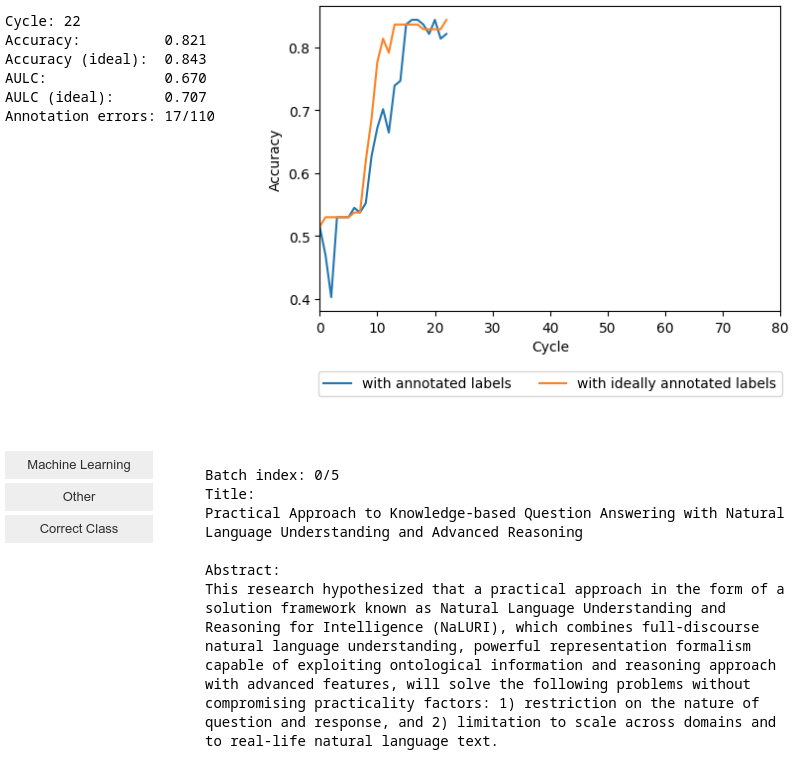